In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# download the dataset to your folder or use it on kaggle notebook directly

train_file = np.load('../../../train.npz')
# train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')
train_data = train_file['data']

test_file = np.load('../../../test_input.npz')
# test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')
test_data = test_file['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :5] # ignore the 6th element when convolving
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [5]:
import sys
sys.path.append('../..')
from TrajectoryDataset import TrajectoryDatasetTrain, TrajectoryDatasetTest
from utils import train_model

sys.path.append('../../..')
from models.simple_cnn import SimpleCNNModel

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.data import Batch

In [7]:
torch.manual_seed(251)
np.random.seed(42)

scale = 5.0

N = len(train_data)
val_size = int(0.05 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=False, center_agent=0, scene=0)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False, center_agent=0, scene=0)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


In [8]:
simple_cnn_model = SimpleCNNModel(train_data.shape[3])

# Define loss function and optimizer
simple_cnn_criterion = nn.MSELoss()  # For regression task

simple_cnn_optimizer = optim.AdamW(simple_cnn_model.parameters(), lr=0.0001, weight_decay=1e-4)

simple_cnn_scheduler = CosineAnnealingLR(simple_cnn_optimizer, T_max=100, eta_min=1e-6)

early_stopping_patience = 20

In [9]:
simple_cnn_model = simple_cnn_model.to(device)
train_model(
    simple_cnn_model, 
    train_dataloader, 
    val_dataloader, 
    device, 
    simple_cnn_optimizer, 
    simple_cnn_criterion, 
    simple_cnn_scheduler, 
    early_stopping_patience,
    "simple_cnn_weights"
)

Epoch:   1%|          | 1/100 [00:06<10:19,  6.26s/epoch]

Epoch 000 | Learning rate 0.000100 | train normalized MSE  63.4818 | val normalized MSE  64.1759, | val unnormalized MAE  25.9164 | val unnormalized MSE 1604.3965


Epoch:   2%|▏         | 2/100 [00:08<06:44,  4.12s/epoch]

Epoch 001 | Learning rate 0.000100 | train normalized MSE  62.4363 | val normalized MSE  64.1716, | val unnormalized MAE  25.9113 | val unnormalized MSE 1604.2910


Epoch:   3%|▎         | 3/100 [00:11<05:47,  3.58s/epoch]

Epoch 002 | Learning rate 0.000100 | train normalized MSE  62.3549 | val normalized MSE  64.1728, | val unnormalized MAE  25.9185 | val unnormalized MSE 1604.3211


Epoch:   4%|▍         | 4/100 [00:14<05:16,  3.30s/epoch]

Epoch 003 | Learning rate 0.000100 | train normalized MSE  62.3500 | val normalized MSE  64.1125, | val unnormalized MAE  26.0597 | val unnormalized MSE 1602.8138


Epoch:   5%|▌         | 5/100 [00:17<04:59,  3.15s/epoch]

Epoch 004 | Learning rate 0.000099 | train normalized MSE  60.9899 | val normalized MSE  59.9169, | val unnormalized MAE  25.3288 | val unnormalized MSE 1497.9216


Epoch:   6%|▌         | 6/100 [00:20<04:51,  3.10s/epoch]

Epoch 005 | Learning rate 0.000099 | train normalized MSE  54.0983 | val normalized MSE  46.3719, | val unnormalized MAE  22.1210 | val unnormalized MSE 1159.2972


Epoch:   7%|▋         | 7/100 [00:23<04:55,  3.18s/epoch]

Epoch 006 | Learning rate 0.000099 | train normalized MSE  39.5119 | val normalized MSE  18.9451, | val unnormalized MAE  13.9667 | val unnormalized MSE 473.6276


Epoch:   8%|▊         | 8/100 [00:26<04:47,  3.13s/epoch]

Epoch 007 | Learning rate 0.000098 | train normalized MSE  17.1855 | val normalized MSE   4.0628, | val unnormalized MAE   6.5406 | val unnormalized MSE 101.5689


Epoch:   9%|▉         | 9/100 [00:29<04:32,  3.00s/epoch]

Epoch 008 | Learning rate 0.000098 | train normalized MSE   8.9932 | val normalized MSE   2.5153, | val unnormalized MAE   5.1535 | val unnormalized MSE  62.8827


Epoch:  10%|█         | 10/100 [00:32<04:33,  3.04s/epoch]

Epoch 009 | Learning rate 0.000098 | train normalized MSE   6.7452 | val normalized MSE   2.3430, | val unnormalized MAE   4.9472 | val unnormalized MSE  58.5739


Epoch:  11%|█         | 11/100 [00:35<04:34,  3.09s/epoch]

Epoch 010 | Learning rate 0.000097 | train normalized MSE   5.9658 | val normalized MSE   1.8441, | val unnormalized MAE   4.4494 | val unnormalized MSE  46.1022


Epoch:  12%|█▏        | 12/100 [00:38<04:29,  3.07s/epoch]

Epoch 011 | Learning rate 0.000097 | train normalized MSE   5.3981 | val normalized MSE   1.8240, | val unnormalized MAE   4.3817 | val unnormalized MSE  45.5990


Epoch:  13%|█▎        | 13/100 [00:42<04:35,  3.16s/epoch]

Epoch 012 | Learning rate 0.000096 | train normalized MSE   5.0826 | val normalized MSE   1.5430, | val unnormalized MAE   4.0458 | val unnormalized MSE  38.5744


Epoch:  14%|█▍        | 14/100 [00:45<04:33,  3.18s/epoch]

Epoch 013 | Learning rate 0.000095 | train normalized MSE   4.7535 | val normalized MSE   1.4738, | val unnormalized MAE   3.9175 | val unnormalized MSE  36.8440


Epoch:  15%|█▌        | 15/100 [00:48<04:20,  3.06s/epoch]

Epoch 014 | Learning rate 0.000095 | train normalized MSE   4.5680 | val normalized MSE   1.6059, | val unnormalized MAE   4.1331 | val unnormalized MSE  40.1465


Epoch:  16%|█▌        | 16/100 [00:50<04:05,  2.93s/epoch]

Epoch 015 | Learning rate 0.000094 | train normalized MSE   4.4142 | val normalized MSE   1.3868, | val unnormalized MAE   3.7860 | val unnormalized MSE  34.6699


Epoch:  17%|█▋        | 17/100 [00:53<03:54,  2.82s/epoch]

Epoch 016 | Learning rate 0.000093 | train normalized MSE   4.2859 | val normalized MSE   1.5047, | val unnormalized MAE   3.9809 | val unnormalized MSE  37.6176


Epoch:  18%|█▊        | 18/100 [00:56<03:52,  2.84s/epoch]

Epoch 017 | Learning rate 0.000092 | train normalized MSE   4.1812 | val normalized MSE   1.4120, | val unnormalized MAE   3.8655 | val unnormalized MSE  35.3011


Epoch:  19%|█▉        | 19/100 [00:59<03:50,  2.84s/epoch]

Epoch 018 | Learning rate 0.000091 | train normalized MSE   4.0256 | val normalized MSE   1.2549, | val unnormalized MAE   3.5980 | val unnormalized MSE  31.3730


Epoch:  20%|██        | 20/100 [01:01<03:42,  2.78s/epoch]

Epoch 019 | Learning rate 0.000091 | train normalized MSE   4.0345 | val normalized MSE   1.3068, | val unnormalized MAE   3.6901 | val unnormalized MSE  32.6703


Epoch:  21%|██        | 21/100 [01:04<03:36,  2.75s/epoch]

Epoch 020 | Learning rate 0.000090 | train normalized MSE   4.0390 | val normalized MSE   1.3310, | val unnormalized MAE   3.7590 | val unnormalized MSE  33.2749


Epoch:  22%|██▏       | 22/100 [01:07<03:32,  2.72s/epoch]

Epoch 021 | Learning rate 0.000089 | train normalized MSE   3.9507 | val normalized MSE   1.2504, | val unnormalized MAE   3.6500 | val unnormalized MSE  31.2610


Epoch:  23%|██▎       | 23/100 [01:09<03:24,  2.66s/epoch]

Epoch 022 | Learning rate 0.000088 | train normalized MSE   3.9257 | val normalized MSE   1.2816, | val unnormalized MAE   3.6799 | val unnormalized MSE  32.0402


Epoch:  24%|██▍       | 24/100 [01:12<03:22,  2.67s/epoch]

Epoch 023 | Learning rate 0.000087 | train normalized MSE   3.7620 | val normalized MSE   1.3632, | val unnormalized MAE   3.8547 | val unnormalized MSE  34.0803


Epoch:  25%|██▌       | 25/100 [01:15<03:24,  2.73s/epoch]

Epoch 024 | Learning rate 0.000086 | train normalized MSE   3.8875 | val normalized MSE   1.1677, | val unnormalized MAE   3.5003 | val unnormalized MSE  29.1918


Epoch:  26%|██▌       | 26/100 [01:17<03:18,  2.69s/epoch]

Epoch 025 | Learning rate 0.000084 | train normalized MSE   3.7796 | val normalized MSE   1.1786, | val unnormalized MAE   3.5029 | val unnormalized MSE  29.4660


Epoch:  27%|██▋       | 27/100 [01:20<03:16,  2.69s/epoch]

Epoch 026 | Learning rate 0.000083 | train normalized MSE   3.7523 | val normalized MSE   1.1488, | val unnormalized MAE   3.4475 | val unnormalized MSE  28.7190


Epoch:  28%|██▊       | 28/100 [01:23<03:20,  2.79s/epoch]

Epoch 027 | Learning rate 0.000082 | train normalized MSE   3.7247 | val normalized MSE   1.1450, | val unnormalized MAE   3.4457 | val unnormalized MSE  28.6259


Epoch:  29%|██▉       | 29/100 [01:26<03:22,  2.85s/epoch]

Epoch 028 | Learning rate 0.000081 | train normalized MSE   3.6047 | val normalized MSE   1.2622, | val unnormalized MAE   3.6773 | val unnormalized MSE  31.5551


Epoch:  30%|███       | 30/100 [01:29<03:16,  2.80s/epoch]

Epoch 029 | Learning rate 0.000080 | train normalized MSE   3.6626 | val normalized MSE   1.0837, | val unnormalized MAE   3.3586 | val unnormalized MSE  27.0915


Epoch:  31%|███       | 31/100 [01:32<03:16,  2.85s/epoch]

Epoch 030 | Learning rate 0.000078 | train normalized MSE   3.6316 | val normalized MSE   1.0874, | val unnormalized MAE   3.3721 | val unnormalized MSE  27.1856


Epoch:  32%|███▏      | 32/100 [01:35<03:12,  2.84s/epoch]

Epoch 031 | Learning rate 0.000077 | train normalized MSE   3.6484 | val normalized MSE   1.1795, | val unnormalized MAE   3.5216 | val unnormalized MSE  29.4884


Epoch:  33%|███▎      | 33/100 [01:37<03:05,  2.76s/epoch]

Epoch 032 | Learning rate 0.000076 | train normalized MSE   3.5831 | val normalized MSE   1.1863, | val unnormalized MAE   3.5696 | val unnormalized MSE  29.6579


Epoch:  34%|███▍      | 34/100 [01:40<03:06,  2.83s/epoch]

Epoch 033 | Learning rate 0.000074 | train normalized MSE   3.5167 | val normalized MSE   1.0937, | val unnormalized MAE   3.3940 | val unnormalized MSE  27.3417


Epoch:  35%|███▌      | 35/100 [01:43<03:05,  2.85s/epoch]

Epoch 034 | Learning rate 0.000073 | train normalized MSE   3.5430 | val normalized MSE   1.1396, | val unnormalized MAE   3.4461 | val unnormalized MSE  28.4912


Epoch:  36%|███▌      | 36/100 [01:46<03:09,  2.96s/epoch]

Epoch 035 | Learning rate 0.000072 | train normalized MSE   3.5626 | val normalized MSE   1.1773, | val unnormalized MAE   3.5574 | val unnormalized MSE  29.4331


Epoch:  37%|███▋      | 37/100 [01:49<03:08,  2.99s/epoch]

Epoch 036 | Learning rate 0.000070 | train normalized MSE   3.6302 | val normalized MSE   1.0734, | val unnormalized MAE   3.3138 | val unnormalized MSE  26.8345


Epoch:  38%|███▊      | 38/100 [01:52<03:05,  3.00s/epoch]

Epoch 037 | Learning rate 0.000069 | train normalized MSE   3.4647 | val normalized MSE   1.2057, | val unnormalized MAE   3.5840 | val unnormalized MSE  30.1434


Epoch:  39%|███▉      | 39/100 [01:56<03:19,  3.27s/epoch]

Epoch 038 | Learning rate 0.000067 | train normalized MSE   3.3451 | val normalized MSE   1.0575, | val unnormalized MAE   3.3203 | val unnormalized MSE  26.4367


Epoch:  40%|████      | 40/100 [02:00<03:18,  3.31s/epoch]

Epoch 039 | Learning rate 0.000066 | train normalized MSE   3.4795 | val normalized MSE   1.1715, | val unnormalized MAE   3.5055 | val unnormalized MSE  29.2886


Epoch:  41%|████      | 41/100 [02:03<03:11,  3.24s/epoch]

Epoch 040 | Learning rate 0.000064 | train normalized MSE   3.4950 | val normalized MSE   1.1860, | val unnormalized MAE   3.5115 | val unnormalized MSE  29.6511


Epoch:  42%|████▏     | 42/100 [02:06<03:07,  3.23s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   3.5198 | val normalized MSE   1.1653, | val unnormalized MAE   3.5058 | val unnormalized MSE  29.1334


Epoch:  43%|████▎     | 43/100 [02:09<03:00,  3.16s/epoch]

Epoch 042 | Learning rate 0.000061 | train normalized MSE   3.4051 | val normalized MSE   1.1304, | val unnormalized MAE   3.4298 | val unnormalized MSE  28.2588


Epoch:  44%|████▍     | 44/100 [02:12<02:56,  3.15s/epoch]

Epoch 043 | Learning rate 0.000060 | train normalized MSE   3.4349 | val normalized MSE   1.0444, | val unnormalized MAE   3.2808 | val unnormalized MSE  26.1100


Epoch:  45%|████▌     | 45/100 [02:15<02:56,  3.21s/epoch]

Epoch 044 | Learning rate 0.000058 | train normalized MSE   3.5428 | val normalized MSE   1.1750, | val unnormalized MAE   3.5778 | val unnormalized MSE  29.3750


Epoch:  46%|████▌     | 46/100 [02:19<02:58,  3.30s/epoch]

Epoch 045 | Learning rate 0.000057 | train normalized MSE   3.4246 | val normalized MSE   1.1201, | val unnormalized MAE   3.4408 | val unnormalized MSE  28.0026


Epoch:  47%|████▋     | 47/100 [02:22<02:53,  3.28s/epoch]

Epoch 046 | Learning rate 0.000055 | train normalized MSE   3.5368 | val normalized MSE   1.2564, | val unnormalized MAE   3.6928 | val unnormalized MSE  31.4093


Epoch:  48%|████▊     | 48/100 [02:25<02:50,  3.27s/epoch]

Epoch 047 | Learning rate 0.000054 | train normalized MSE   3.3277 | val normalized MSE   1.1347, | val unnormalized MAE   3.4921 | val unnormalized MSE  28.3677


Epoch:  49%|████▉     | 49/100 [02:29<02:44,  3.22s/epoch]

Epoch 048 | Learning rate 0.000052 | train normalized MSE   3.3940 | val normalized MSE   1.1675, | val unnormalized MAE   3.5247 | val unnormalized MSE  29.1884


Epoch:  50%|█████     | 50/100 [02:32<02:38,  3.18s/epoch]

Epoch 049 | Learning rate 0.000051 | train normalized MSE   3.3160 | val normalized MSE   1.0777, | val unnormalized MAE   3.3437 | val unnormalized MSE  26.9436


Epoch:  51%|█████     | 51/100 [02:35<02:34,  3.15s/epoch]

Epoch 050 | Learning rate 0.000049 | train normalized MSE   3.3968 | val normalized MSE   1.0762, | val unnormalized MAE   3.3733 | val unnormalized MSE  26.9048


Epoch:  52%|█████▏    | 52/100 [02:38<02:34,  3.21s/epoch]

Epoch 051 | Learning rate 0.000047 | train normalized MSE   3.3724 | val normalized MSE   1.0820, | val unnormalized MAE   3.3828 | val unnormalized MSE  27.0508


Epoch:  53%|█████▎    | 53/100 [02:41<02:32,  3.24s/epoch]

Epoch 052 | Learning rate 0.000046 | train normalized MSE   3.3551 | val normalized MSE   1.1867, | val unnormalized MAE   3.5806 | val unnormalized MSE  29.6672


Epoch:  54%|█████▍    | 54/100 [02:44<02:26,  3.18s/epoch]

Epoch 053 | Learning rate 0.000044 | train normalized MSE   3.3229 | val normalized MSE   1.1176, | val unnormalized MAE   3.4145 | val unnormalized MSE  27.9405


Epoch:  55%|█████▌    | 55/100 [02:47<02:21,  3.13s/epoch]

Epoch 054 | Learning rate 0.000043 | train normalized MSE   3.4044 | val normalized MSE   1.0438, | val unnormalized MAE   3.3060 | val unnormalized MSE  26.0957


Epoch:  56%|█████▌    | 56/100 [02:50<02:16,  3.11s/epoch]

Epoch 055 | Learning rate 0.000041 | train normalized MSE   3.2490 | val normalized MSE   1.0574, | val unnormalized MAE   3.3184 | val unnormalized MSE  26.4351


Epoch:  57%|█████▋    | 57/100 [02:54<02:12,  3.09s/epoch]

Epoch 056 | Learning rate 0.000040 | train normalized MSE   3.4486 | val normalized MSE   1.0801, | val unnormalized MAE   3.3674 | val unnormalized MSE  27.0020


Epoch:  58%|█████▊    | 58/100 [02:57<02:12,  3.15s/epoch]

Epoch 057 | Learning rate 0.000038 | train normalized MSE   3.2579 | val normalized MSE   1.0761, | val unnormalized MAE   3.3942 | val unnormalized MSE  26.9022


Epoch:  59%|█████▉    | 59/100 [03:00<02:09,  3.16s/epoch]

Epoch 058 | Learning rate 0.000037 | train normalized MSE   3.4034 | val normalized MSE   1.1047, | val unnormalized MAE   3.4178 | val unnormalized MSE  27.6172


Epoch:  60%|██████    | 60/100 [03:03<02:04,  3.12s/epoch]

Epoch 059 | Learning rate 0.000035 | train normalized MSE   3.2659 | val normalized MSE   1.1277, | val unnormalized MAE   3.4681 | val unnormalized MSE  28.1924


Epoch:  61%|██████    | 61/100 [03:06<02:00,  3.10s/epoch]

Epoch 060 | Learning rate 0.000034 | train normalized MSE   3.1962 | val normalized MSE   0.9855, | val unnormalized MAE   3.1469 | val unnormalized MSE  24.6369


Epoch:  62%|██████▏   | 62/100 [03:09<01:56,  3.08s/epoch]

Epoch 061 | Learning rate 0.000032 | train normalized MSE   3.1642 | val normalized MSE   1.0457, | val unnormalized MAE   3.2978 | val unnormalized MSE  26.1431


Epoch:  63%|██████▎   | 63/100 [03:12<01:53,  3.07s/epoch]

Epoch 062 | Learning rate 0.000031 | train normalized MSE   3.0884 | val normalized MSE   1.1032, | val unnormalized MAE   3.4349 | val unnormalized MSE  27.5800


Epoch:  64%|██████▍   | 64/100 [03:15<01:52,  3.12s/epoch]

Epoch 063 | Learning rate 0.000029 | train normalized MSE   3.2347 | val normalized MSE   1.1536, | val unnormalized MAE   3.5247 | val unnormalized MSE  28.8406


Epoch:  65%|██████▌   | 65/100 [03:19<01:50,  3.17s/epoch]

Epoch 064 | Learning rate 0.000028 | train normalized MSE   3.1401 | val normalized MSE   1.0561, | val unnormalized MAE   3.3251 | val unnormalized MSE  26.4032


Epoch:  66%|██████▌   | 66/100 [03:22<01:46,  3.13s/epoch]

Epoch 065 | Learning rate 0.000027 | train normalized MSE   3.2269 | val normalized MSE   1.0271, | val unnormalized MAE   3.2692 | val unnormalized MSE  25.6764


Epoch:  67%|██████▋   | 67/100 [03:25<01:42,  3.09s/epoch]

Epoch 066 | Learning rate 0.000025 | train normalized MSE   3.2850 | val normalized MSE   1.0486, | val unnormalized MAE   3.3098 | val unnormalized MSE  26.2149


Epoch:  68%|██████▊   | 68/100 [03:28<01:38,  3.09s/epoch]

Epoch 067 | Learning rate 0.000024 | train normalized MSE   3.1320 | val normalized MSE   1.0747, | val unnormalized MAE   3.3574 | val unnormalized MSE  26.8686


Epoch:  69%|██████▉   | 69/100 [03:31<01:35,  3.08s/epoch]

Epoch 068 | Learning rate 0.000023 | train normalized MSE   3.2111 | val normalized MSE   1.0106, | val unnormalized MAE   3.2500 | val unnormalized MSE  25.2641


Epoch:  70%|███████   | 70/100 [03:35<01:37,  3.27s/epoch]

Epoch 069 | Learning rate 0.000021 | train normalized MSE   3.1501 | val normalized MSE   1.0780, | val unnormalized MAE   3.3690 | val unnormalized MSE  26.9497


Epoch:  71%|███████   | 71/100 [03:38<01:35,  3.30s/epoch]

Epoch 070 | Learning rate 0.000020 | train normalized MSE   3.2040 | val normalized MSE   1.0886, | val unnormalized MAE   3.4107 | val unnormalized MSE  27.2146


Epoch:  72%|███████▏  | 72/100 [03:41<01:31,  3.26s/epoch]

Epoch 071 | Learning rate 0.000019 | train normalized MSE   3.2725 | val normalized MSE   1.0810, | val unnormalized MAE   3.4023 | val unnormalized MSE  27.0260


Epoch:  73%|███████▎  | 73/100 [03:44<01:26,  3.20s/epoch]

Epoch 072 | Learning rate 0.000018 | train normalized MSE   3.1781 | val normalized MSE   1.0991, | val unnormalized MAE   3.4488 | val unnormalized MSE  27.4780


Epoch:  74%|███████▍  | 74/100 [03:47<01:22,  3.19s/epoch]

Epoch 073 | Learning rate 0.000017 | train normalized MSE   3.2528 | val normalized MSE   1.0472, | val unnormalized MAE   3.3277 | val unnormalized MSE  26.1808


Epoch:  75%|███████▌  | 75/100 [03:50<01:18,  3.14s/epoch]

Epoch 074 | Learning rate 0.000015 | train normalized MSE   3.0922 | val normalized MSE   1.0915, | val unnormalized MAE   3.4145 | val unnormalized MSE  27.2870


Epoch:  76%|███████▌  | 76/100 [03:53<01:15,  3.14s/epoch]

Epoch 075 | Learning rate 0.000014 | train normalized MSE   3.2386 | val normalized MSE   1.0111, | val unnormalized MAE   3.2365 | val unnormalized MSE  25.2768


Epoch:  77%|███████▋  | 77/100 [03:57<01:15,  3.28s/epoch]

Epoch 076 | Learning rate 0.000013 | train normalized MSE   3.2254 | val normalized MSE   1.0843, | val unnormalized MAE   3.3840 | val unnormalized MSE  27.1078


Epoch:  78%|███████▊  | 78/100 [04:00<01:12,  3.30s/epoch]

Epoch 077 | Learning rate 0.000012 | train normalized MSE   3.1440 | val normalized MSE   1.0527, | val unnormalized MAE   3.3166 | val unnormalized MSE  26.3164


Epoch:  79%|███████▉  | 79/100 [04:04<01:11,  3.41s/epoch]

Epoch 078 | Learning rate 0.000011 | train normalized MSE   3.2020 | val normalized MSE   1.0759, | val unnormalized MAE   3.3745 | val unnormalized MSE  26.8985


Epoch:  80%|████████  | 80/100 [04:08<01:09,  3.48s/epoch]

Epoch 079 | Learning rate 0.000010 | train normalized MSE   3.1111 | val normalized MSE   1.0521, | val unnormalized MAE   3.3302 | val unnormalized MSE  26.3035


Epoch:  80%|████████  | 80/100 [04:11<01:02,  3.15s/epoch]

Epoch 080 | Learning rate 0.000010 | train normalized MSE   3.2185 | val normalized MSE   1.0319, | val unnormalized MAE   3.2744 | val unnormalized MSE  25.7981
Early stop!


In [10]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale, center_agent=0, scene=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

simple_cnn_weights = torch.load("simple_cnn_weights.pt")
simple_cnn_model = SimpleCNNModel(train_data.shape[3])
simple_cnn_model.load_state_dict(simple_cnn_weights)

# also save entire model
torch.save(simple_cnn_model, "full_simple_cnn_model.pt")

In [ ]:
test_dataset.generate_submission_predictions(simple_cnn_model, device, output_file_name='simple_cnn_submission')

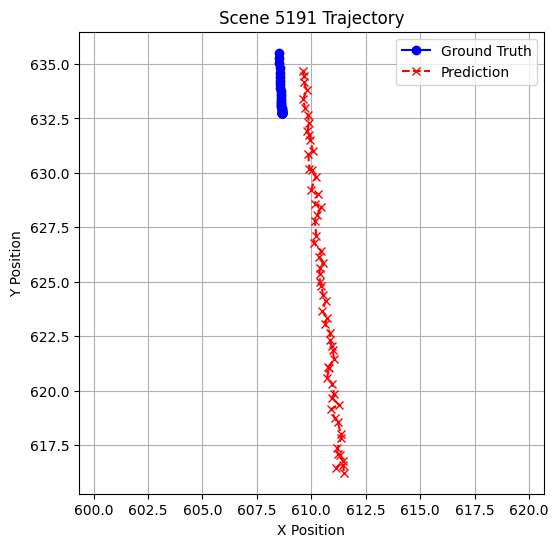

In [15]:
from utils import visualize_trajectory

# run this cell to visualize how the model's predicted trajectory compares to the real one on some data points
visualize_trajectory(train_dataset, simple_cnn_model, np.random.randint(0, len(train_dataset)))